In [1]:
import datetime
import numpy as np
import pandas as pd
from pydmd import HODMD
from pydmd.preprocessing import hankel_preprocessing
from matplotlib import pyplot as plt
from src.datasource import YahooDataSource
from src.prediction import PredictionModeling
from src.bayesianopt import bayesianOpt
from src.utils import buy_signal_plots,trade_strategy
from src.utils import find_cointegrated_pairs,get_top_k_pairs,get_cointergrated_coeff
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

c:\Users\aayus\Documents\GitHub\SpreadPrediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Extraction

In [2]:
# Extract the Data from the Yahoo Data Source
start_date = datetime.datetime(2017, 3, 29)
end_date = datetime.datetime(2024, 3, 29)
tickers  =  ['IWV', 'VT', 'VTI','ADBE','MSFT','VFH',
                 'DIA', 'RSP', 'IOO', 'IVV', 'SPY',
                 'SHE', 'IWM', 'OEF', 'QQQ',
                 'CVY', 'RPG', 'RPV', 'IWB', 'IWF', 
                 'IWD', 'IVW', 'IVE', 'PKW', 
                 'PRF', 'SDY', 'VV', 'VUG', 
                 'VTV', 'MGC', 'MGK', 'MGV', 'VIG', 
                 'VYM', 'DTN', 'DLN', 'MDY', 'DVY', 
                 'IWR', 'IWP', 'IWS', 'IJH', 'IJK', 
                 'IJJ', 'PDP', 'DON', 'IWC', 'IWM', 
                 'EWT', 'EPI', 'XLY', 'IYC', 'ITB', 
                 'XHB', 'VCR','XLP', 'IYK', 'VDC', 
                 'XLE', 'IYE', 'IGE', 'OIH', 'XOP', 
                 'VDE', 'QCLN', 'XLF','IYF', 'KBE', 
                 'KRE']
columns =   ["High","Close","Low","Volume"]
ds = YahooDataSource(start_date,end_date,tickers,columns)

In [3]:
# Get only Close column data
df_pair_search = ds.get_data_by_column_tickers(columns=["Close"],tickers=-1)

In [4]:
df_pair_search.head(n=5)
scores, pvalues, pairs = find_cointegrated_pairs(df_pair_search)

top_pairs = get_top_k_pairs(pairs,5)
print("Top pairs",top_pairs)

# Get first pair
tickers = ds.get_tickers(top_pairs[0][0])
print("Top ticker",tickers)

Top pairs [(('PKW_Close', 'IWD_Close'), 0.0031117488393787676), (('IJK_Close', 'VT_Close'), 0.008791513349472408), (('VFH_Close', 'DTN_Close'), 0.010189621155979071), (('IWD_Close', 'PRF_Close'), 0.010709064260801598), (('CVY_Close', 'EPI_Close'), 0.014127786770143582)]
Top ticker ['PKW', 'IWD']


In [5]:
first_series = 'IWD_Close'
second_series =  'PKW_Close'

In [6]:
# Gather High, Low ,Close , Volume of selected stocks
columns = ["High","Close","Low","Volume"]
df_raw = ds.get_data_by_column_tickers(columns=columns,tickers=tickers)

In [7]:
df_raw

,IWD_High,IWD_Volume,IWD_Close,IWD_Low,PKW_High,PKW_Volume,PKW_Close,PKW_Low
0,98.205213,1465100,98.042831,97.641156,47.390660,47200,47.299152,47.207648
1,98.623999,1779000,98.512894,97.906109,47.710932,42800,47.692631,47.290008
2,98.564177,2455400,98.230873,98.179591,47.720079,60900,47.537067,47.537067
3,98.299220,2376600,97.974464,97.316404,47.582829,86200,47.290012,47.042947
4,98.162494,1315700,98.136856,97.683905,47.280854,66700,47.189350,47.106995
...,...,...,...,...,...,...,...,...
1757,177.300003,1125200,175.990005,175.949997,107.220001,21100,106.610001,106.559998
1758,176.559998,2038600,175.779999,175.750000,106.849998,32200,106.449997,106.440002
1759,176.259995,1180400,175.649994,175.649994,106.769997,17900,106.589996,106.510002
1760,178.539993,2186800,178.539993,176.679993,107.849998,16900,107.849998,106.919998


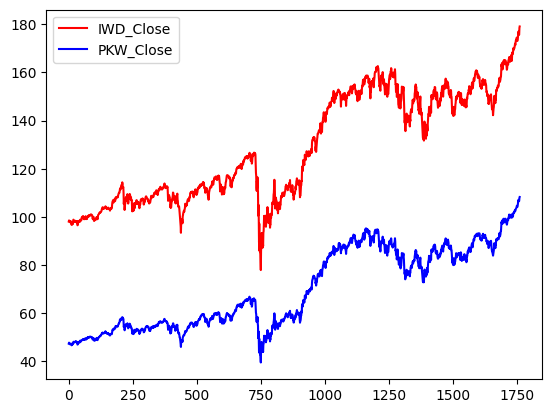

In [8]:
plt.plot(df_raw[first_series],color='r')
plt.plot(df_raw[second_series],color='b')
plt.legend([f'{first_series}',f'{second_series}'])

In [9]:
# Find ratio between co-integrated pairs
coeff = get_cointergrated_coeff(df_raw[first_series],df_raw[second_series])
print(coeff)

-1.807631582914083


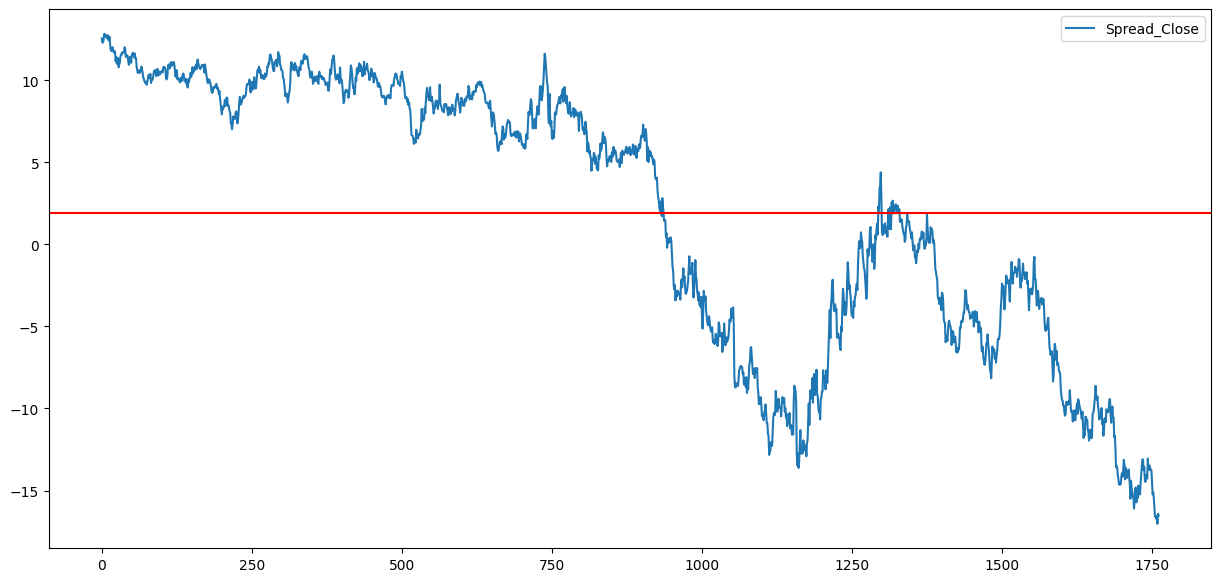

In [10]:
df_raw['Spread_Close'] = df_raw[first_series] + (df_raw[second_series] * coeff)
df_raw['Spread_Close'].plot(figsize=(15,7))
plt.axhline(df_raw['Spread_Close'].mean(),c='red')
plt.legend(['Spread_Close'])

In [13]:
pm = PredictionModeling(df_raw,"Spread_Close",0.60,1)

NameError: name 'pd' is not defined

In [13]:
pm.add_arima_forecast("Spread_Close",order=(1,1,0))

In [14]:
pm.add_dmd_forecast("Spread_Close",svd_rank=0)

In [15]:
pm.data.head()

,IWD_Volume,IWD_Low,IWD_Close,IWD_High,PKW_Volume,PKW_Low,PKW_Close,PKW_High,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1,Spread_Close_DMD_forecast_1,Spread_Close_DMD_forecasts_1
0,1465100,97.641156,98.042831,98.205213,47200,47.207652,47.299156,47.390664,12.543382,[12.302171464783044],12.302171,12.302171,NaN,NaN,NaN,NaN
1,1779000,97.906086,98.512871,98.623976,42800,47.290004,47.692627,47.710928,12.302171,[12.301345968782528],12.301346,12.301346,NaN,NaN,NaN,NaN
2,2455400,98.179576,98.230858,98.564162,60900,47.537071,47.537071,47.720083,12.301346,[12.491565373027015],12.491565,12.491565,NaN,NaN,NaN,NaN
3,2376600,97.316412,97.974472,98.299228,86200,47.042940,47.290005,47.582822,12.491565,[12.835881320106424],12.835881,12.835881,NaN,NaN,NaN,NaN
4,1315700,97.683897,98.136848,98.162486,66700,47.106999,47.189354,47.280858,12.835881,[12.79810946389594],12.798109,12.798109,NaN,NaN,NaN,NaN


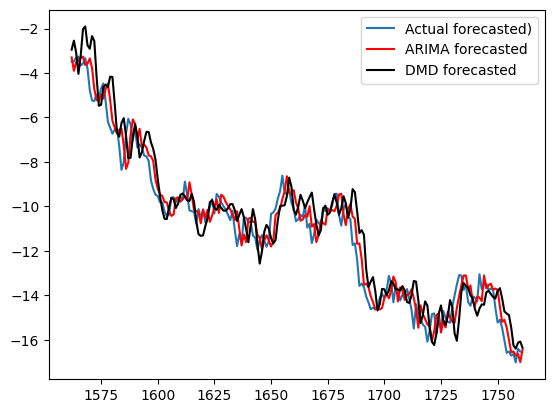

In [41]:
plt.plot(pm.data["Spread_Close_Actual_value_fore_perod_1"][-200:])
plt.plot(pm.data["Spread_Close_ARIMA_forecast_1"][-200:],color='r')
plt.plot(pm.data["Spread_Close_DMD_forecast_1"][-200:],color='k')
plt.legend(["Actual forecasted)","ARIMA forecasted","DMD forecasted"])

In [17]:
pm.data

,IWD_Volume,IWD_Low,IWD_Close,IWD_High,PKW_Volume,PKW_Low,PKW_Close,PKW_High,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1,Spread_Close_DMD_forecast_1,Spread_Close_DMD_forecasts_1
0,1465100,97.641156,98.042831,98.205213,47200,47.207652,47.299156,47.390664,12.543382,[12.302171464783044],12.302171,12.302171,NaN,NaN,NaN,NaN
1,1779000,97.906086,98.512871,98.623976,42800,47.290004,47.692627,47.710928,12.302171,[12.301345968782528],12.301346,12.301346,NaN,NaN,NaN,NaN
2,2455400,98.179576,98.230858,98.564162,60900,47.537071,47.537071,47.720083,12.301346,[12.491565373027015],12.491565,12.491565,NaN,NaN,NaN,NaN
3,2376600,97.316412,97.974472,98.299228,86200,47.042940,47.290005,47.582822,12.491565,[12.835881320106424],12.835881,12.835881,NaN,NaN,NaN,NaN
4,1315700,97.683897,98.136848,98.162486,66700,47.106999,47.189354,47.280858,12.835881,[12.79810946389594],12.798109,12.798109,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,1125200,175.949997,175.990005,177.300003,21100,106.559998,106.610001,107.220001,-16.721600,[-16.642378980334485],-16.642379,-16.642379,-16.529960,[-16.529960111804456],-16.260141,[-16.260141336099093]
1758,2038600,175.750000,175.779999,176.559998,32200,106.440002,106.449997,106.849998,-16.642379,[-17.025451183140888],-17.025451,-17.025451,-16.712702,[-16.712702290816004],-16.401975,[-16.401975147683082]
1759,1180400,175.649994,175.649994,176.259995,17900,106.510002,106.589996,106.769997,-17.025451,[-16.413071464572056],-16.413071,-16.413071,-16.646003,[-16.64600321315923],-16.136672,[-16.136672191565953]
1760,2186800,176.679993,178.539993,178.539993,16900,106.919998,107.849998,107.849998,-16.413071,[-16.529972972737824],-16.529973,-16.529973,-17.007899,[-17.00789915685856],-16.083161,[-16.08316133558442]


In [18]:
pm.data

,IWD_Volume,IWD_Low,IWD_Close,IWD_High,PKW_Volume,PKW_Low,PKW_Close,PKW_High,Spread_Close,Spread_Close_Actual_fore_perod_1,Spread_Close_Actual_value_fore_perod_1,Spread_Close_Actual_mean_fore_perod_1,Spread_Close_ARIMA_forecast_1,Spread_Close_ARIMA_forecasts_1,Spread_Close_DMD_forecast_1,Spread_Close_DMD_forecasts_1
0,1465100,97.641156,98.042831,98.205213,47200,47.207652,47.299156,47.390664,12.543382,[12.302171464783044],12.302171,12.302171,NaN,NaN,NaN,NaN
1,1779000,97.906086,98.512871,98.623976,42800,47.290004,47.692627,47.710928,12.302171,[12.301345968782528],12.301346,12.301346,NaN,NaN,NaN,NaN
2,2455400,98.179576,98.230858,98.564162,60900,47.537071,47.537071,47.720083,12.301346,[12.491565373027015],12.491565,12.491565,NaN,NaN,NaN,NaN
3,2376600,97.316412,97.974472,98.299228,86200,47.042940,47.290005,47.582822,12.491565,[12.835881320106424],12.835881,12.835881,NaN,NaN,NaN,NaN
4,1315700,97.683897,98.136848,98.162486,66700,47.106999,47.189354,47.280858,12.835881,[12.79810946389594],12.798109,12.798109,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,1125200,175.949997,175.990005,177.300003,21100,106.559998,106.610001,107.220001,-16.721600,[-16.642378980334485],-16.642379,-16.642379,-16.529960,[-16.529960111804456],-16.260141,[-16.260141336099093]
1758,2038600,175.750000,175.779999,176.559998,32200,106.440002,106.449997,106.849998,-16.642379,[-17.025451183140888],-17.025451,-17.025451,-16.712702,[-16.712702290816004],-16.401975,[-16.401975147683082]
1759,1180400,175.649994,175.649994,176.259995,17900,106.510002,106.589996,106.769997,-17.025451,[-16.413071464572056],-16.413071,-16.413071,-16.646003,[-16.64600321315923],-16.136672,[-16.136672191565953]
1760,2186800,176.679993,178.539993,178.539993,16900,106.919998,107.849998,107.849998,-16.413071,[-16.529972972737824],-16.529973,-16.529973,-17.007899,[-17.00789915685856],-16.083161,[-16.08316133558442]


# Data Prepareation of Hyperparameter Tuning for Trading Strategy

In [19]:
total_length =(len(pm.data) - pm.train_end_index)-1
train_size = 0.60
length_param_training = int((len(pm.data) - pm.train_end_index)*0.60)

In [20]:
test_data = pm.data[[first_series,second_series,"Spread_Close","Spread_Close_Actual_value_fore_perod_1","Spread_Close_ARIMA_forecast_1","Spread_Close_DMD_forecast_1"]][total_length:-1]

In [21]:
spread_actual_val = test_data["Spread_Close_Actual_value_fore_perod_1"][:length_param_training]
spread_naive_val= test_data["Spread_Close"][:length_param_training]
spread_ARIMA_val = test_data["Spread_Close_ARIMA_forecast_1"][:length_param_training]
spread_DMD_val = test_data["Spread_Close_DMD_forecast_1"][:length_param_training]
S1_val = test_data[first_series][:length_param_training]
S2_val = test_data[second_series][:length_param_training]
spread_actual_test = test_data["Spread_Close_Actual_value_fore_perod_1"][length_param_training:]
spread_naive_test= test_data["Spread_Close"][length_param_training:]
spread_ARIMA_test = test_data["Spread_Close_ARIMA_forecast_1"][length_param_training:]
spread_DMD_test = test_data["Spread_Close_DMD_forecast_1"][length_param_training:]
S1_test = test_data[first_series][length_param_training:]
S2_test = test_data[second_series][length_param_training:]

# Define set of Hyper parameters

In [22]:
sell_treshold_params = np.linspace(0.5,1,20)
buy_threshold_params = np.linspace(-0.5,-1,20)
clear_threshold_params = np.linspace(0,0.5,10)
window1_param = np.arange(10,100,2)
window2_param = np.arange(1,7,1)
window_param = list(zip(window1_param,window2_param))

param_grid = { 'window1':window1_param,
              'window2':window2_param,
              "sell_threshold":sell_treshold_params,
              "buy_threshold":buy_threshold_params,
              "clear_threshold":clear_threshold_params }
config_dict = {"num_iteration":150}

#  Trading Strategy using Actual Spread (Forecasted) 

Best score: 8433.68603134124: 100%|██████████| 150/150 [01:46<00:00,  1.40it/s]  


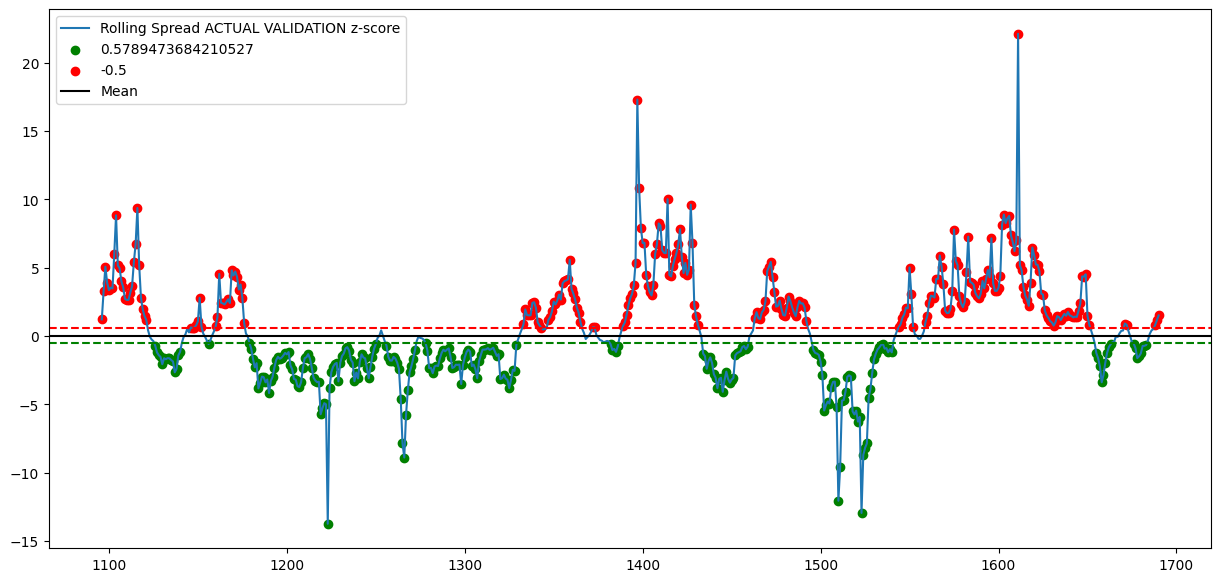

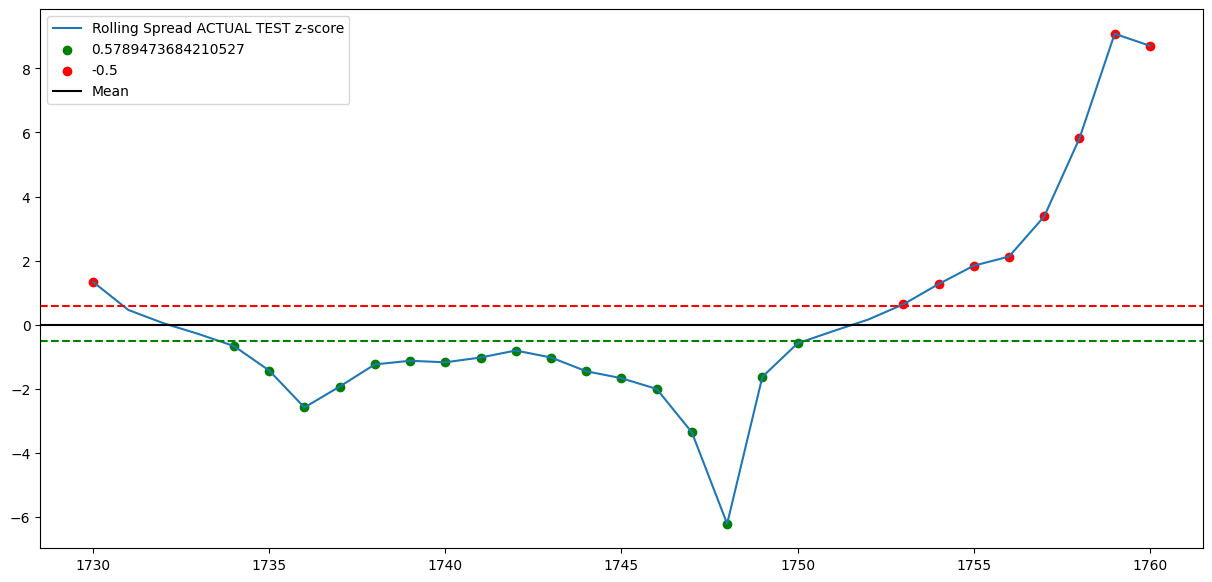

Optimal Parameters {'buy_threshold': -0.5, 'clear_threshold': 0.1111111111111111, 'sell_threshold': 0.5789473684210527, 'window1': 40, 'window2': 6}
Money on validation data 8433.68603134124
Money on test data 1166.929603902494


In [23]:
# Optimize the Parameters using Validation data
byopt = bayesianOpt()
params = byopt.optimize(spread_actual_val,S1_val,S2_val,param_grid,config_dict)

window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]


buy_signal_plots(spread_actual_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="ACTUAL VALIDATION")
buy_signal_plots(spread_actual_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="ACTUAL TEST")

money_val = trade_strategy(S1_val,S2_val,spread_actual_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)

# Run the algorithm on test data
money_test = trade_strategy(S1_test,S2_test,spread_actual_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)


In [3]:
money_val = trade_strategy(S1_val[-100:],S2_val[-100:],spread_actual_val[-100:],window1,window2,1,-1,clear_threshold)

NameError: name 'S1_val' is not defined

# Trading Strategy using Trading Strategy using Actual Spread  

Best score: 4416.42042884578: 100%|██████████| 150/150 [01:40<00:00,  1.50it/s] 

{'buy_threshold': -0.9473684210526315, 'clear_threshold': 0.1111111111111111, 'sell_threshold': 0.5, 'window1': 28, 'window2': 6}


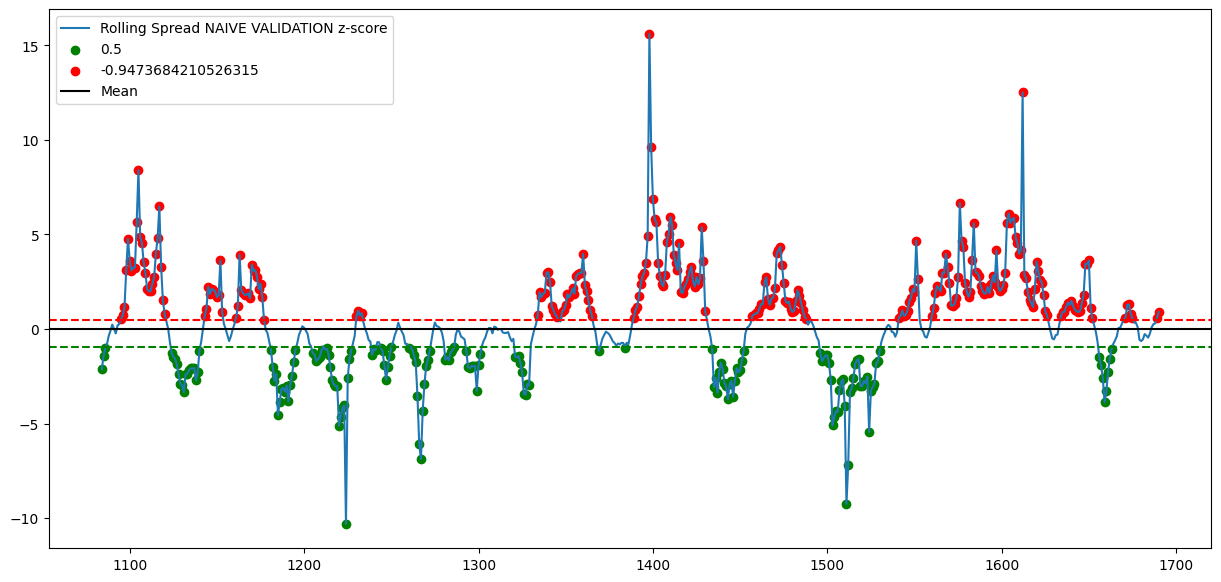

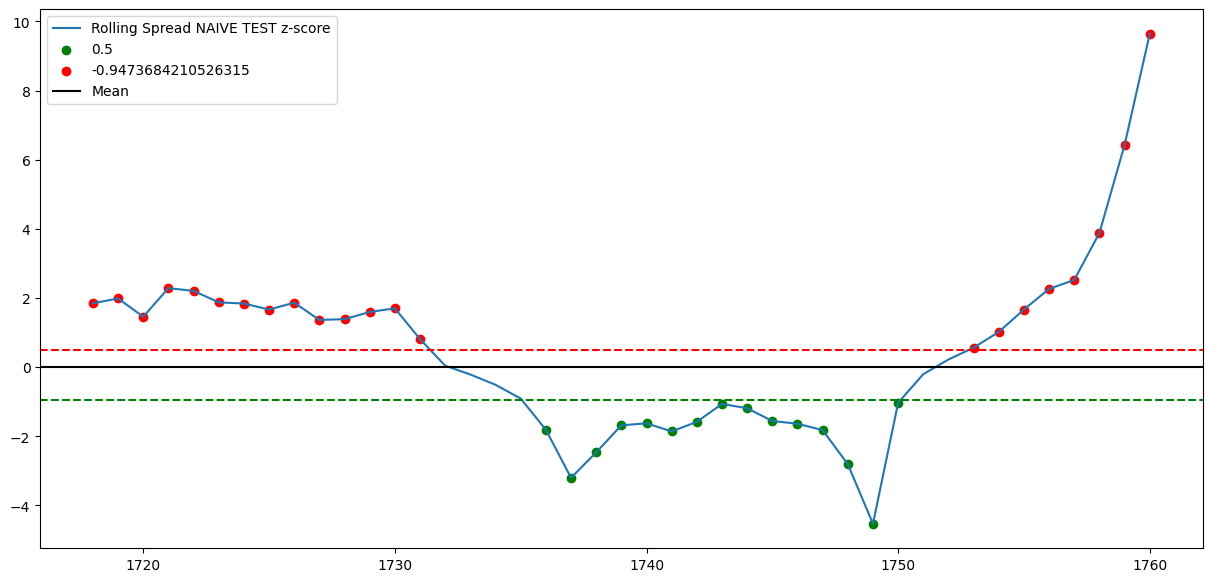

Optimal Parameters {'buy_threshold': -0.9473684210526315, 'clear_threshold': 0.1111111111111111, 'sell_threshold': 0.5, 'window1': 28, 'window2': 6}
Money on validation data 4416.42042884578
Money on test data 765.83733938769


In [24]:

byopt = bayesianOpt()
params = byopt.optimize(spread_naive_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]


buy_signal_plots(spread_naive_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="NAIVE VALIDATION")
buy_signal_plots(spread_naive_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="NAIVE TEST")

money_val = trade_strategy(S1_val,S2_val,spread_naive_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)
money_test = trade_strategy(S1_test,S2_test,spread_naive_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)


# Trading Strategy using Trading Strategy using ARIMA

Best score: 7490.388591484729: 100%|██████████| 150/150 [01:41<00:00,  1.48it/s]

{'buy_threshold': -0.5263157894736842, 'clear_threshold': 0.16666666666666666, 'sell_threshold': 0.5526315789473684, 'window1': 42, 'window2': 6}


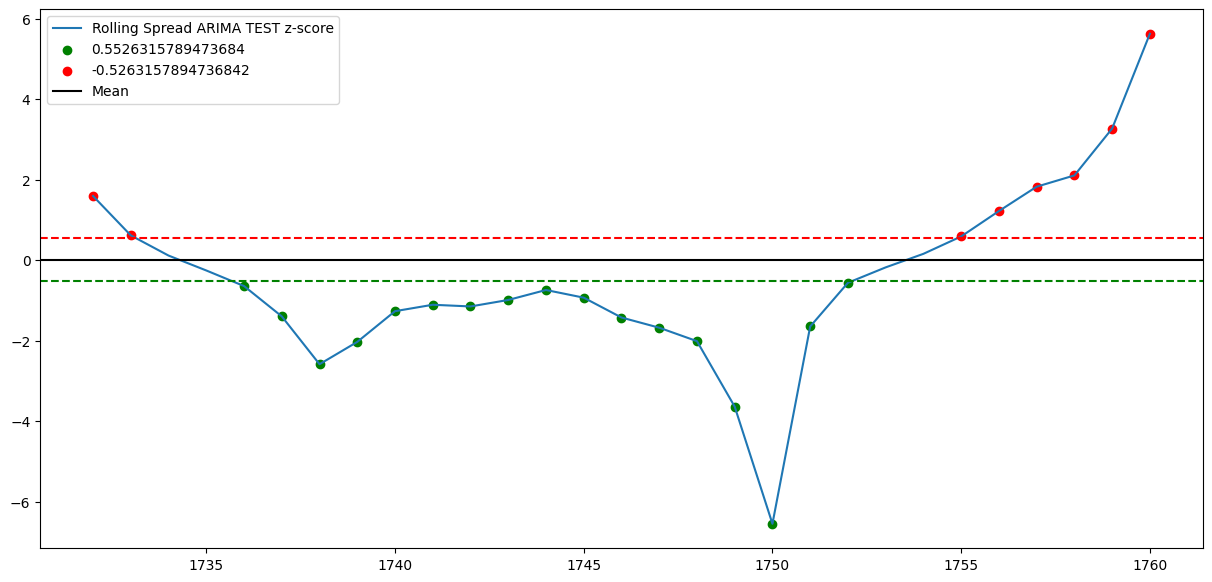

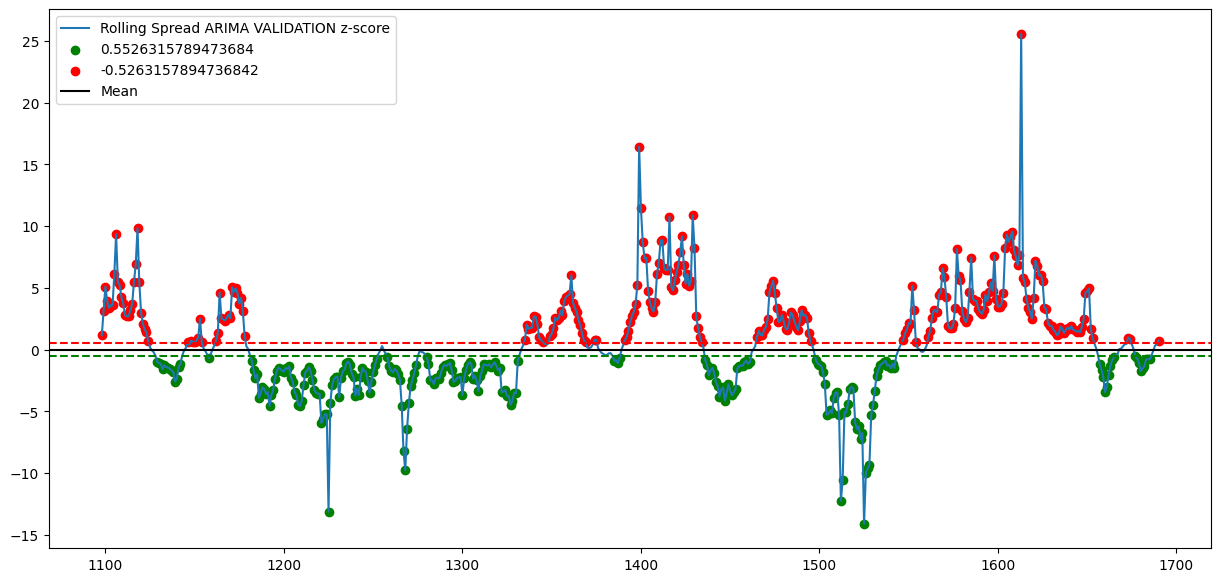

Optimal Parameters {'buy_threshold': -0.5263157894736842, 'clear_threshold': 0.16666666666666666, 'sell_threshold': 0.5526315789473684, 'window1': 42, 'window2': 6}
Money on validation data 7490.388591484729
Money on test data 520.4981592361619


In [25]:
byopt = bayesianOpt()
params = byopt.optimize(spread_ARIMA_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]

money_test = trade_strategy(S1_test,S2_test,spread_ARIMA_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_ARIMA_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="ARIMA TEST")

money_val = trade_strategy(S1_val,S2_val,spread_ARIMA_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_ARIMA_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="ARIMA VALIDATION")

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)



# Trading Strategy using Dynamic Mode Decomposition

Best score: 9483.993137829228: 100%|██████████| 150/150 [01:38<00:00,  1.52it/s]

{'buy_threshold': -0.5, 'clear_threshold': 0.2777777777777778, 'sell_threshold': 0.5, 'window1': 44, 'window2': 6}


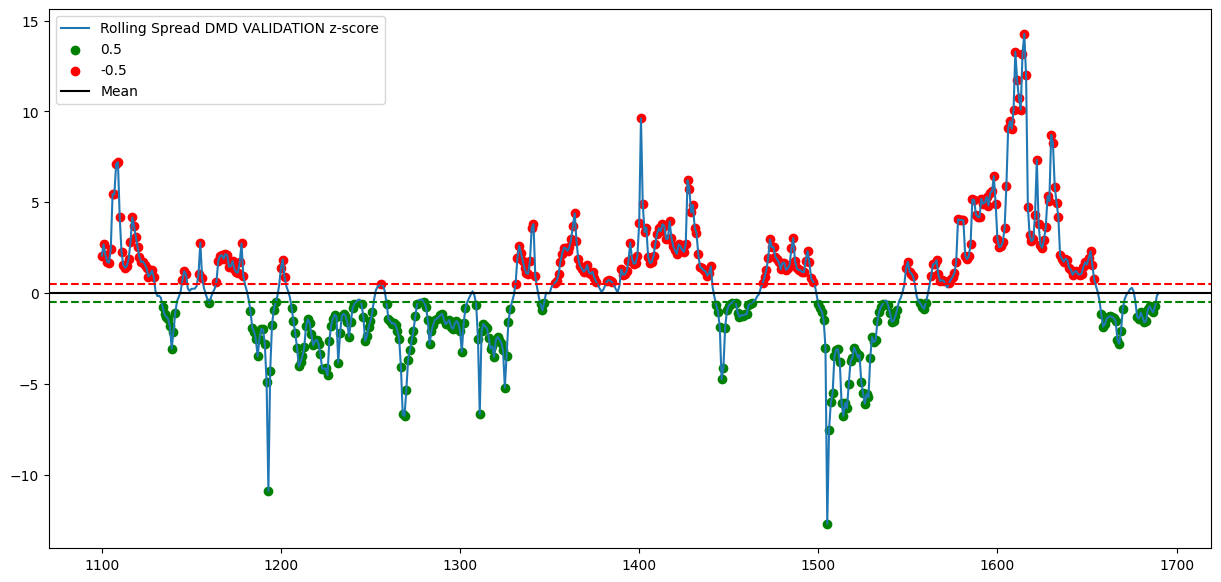

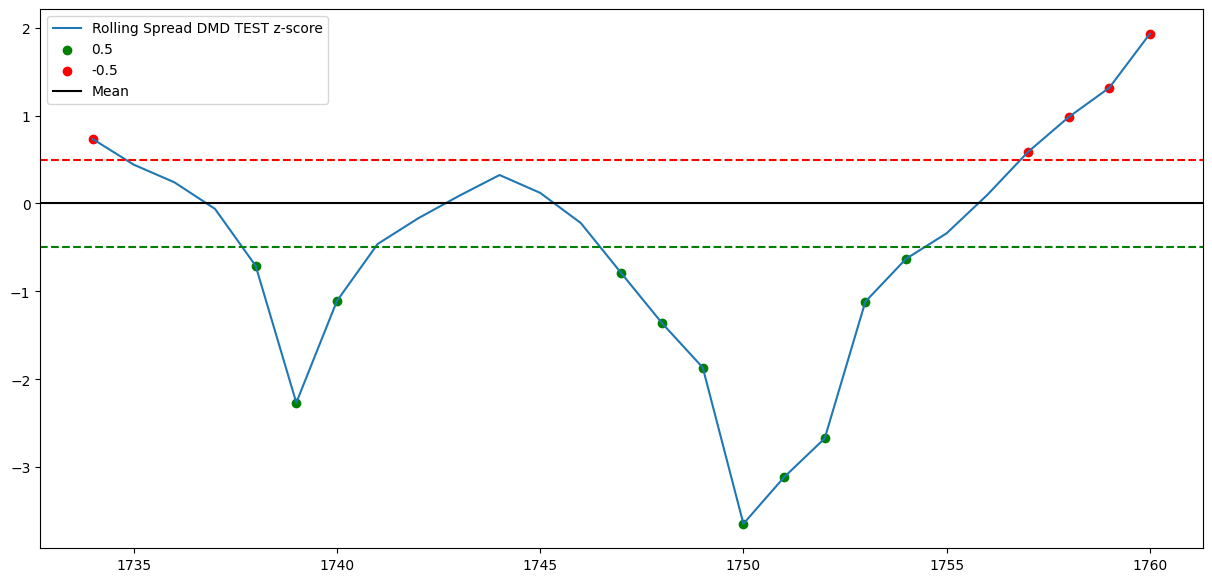

Optimal Parameters {'buy_threshold': -0.5, 'clear_threshold': 0.2777777777777778, 'sell_threshold': 0.5, 'window1': 44, 'window2': 6}
Money on validation data 9483.993137829228
Money on test data 290.051957405316


In [26]:
byopt = bayesianOpt()
params = byopt.optimize(spread_DMD_val,S1_val,S2_val,param_grid,config_dict)
print(byopt.optimize_results["best_params"])
window1 = byopt.optimize_results["best_params"]["window1"]
window2 = byopt.optimize_results["best_params"]["window2"]
sell_threshold = byopt.optimize_results["best_params"]["sell_threshold"]
buy_threshold = byopt.optimize_results["best_params"]["buy_threshold"]
clear_threshold = byopt.optimize_results["best_params"]["clear_threshold"]

money_val = trade_strategy(S1_val,S2_val,spread_DMD_val,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_DMD_val,S1_val,S2_val,window1,window2,sell_threshold,buy_threshold,label="DMD VALIDATION")

money_test = trade_strategy(S1_test,S2_test,spread_DMD_test,window1,window2,sell_threshold,buy_threshold,clear_threshold)
buy_signal_plots(spread_DMD_test,S1_test,S2_test,window1,window2,sell_threshold,buy_threshold,label="DMD TEST")

print("Optimal Parameters",byopt.optimize_results["best_params"])
print("Money on validation data",money_val)
print("Money on test data",money_test)

# Parameter Initialization for ARIMA

In [27]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [28]:
result = adfuller(pm.data['Spread_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.481064
p-value: 0.895659


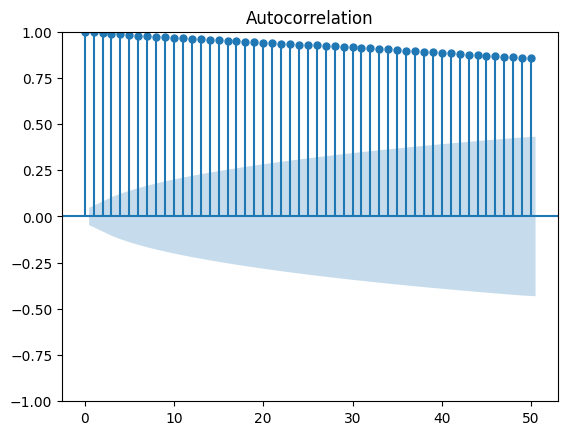

In [29]:
plot_acf(pm.data['Spread_Close'],lags=50)
plt.show()

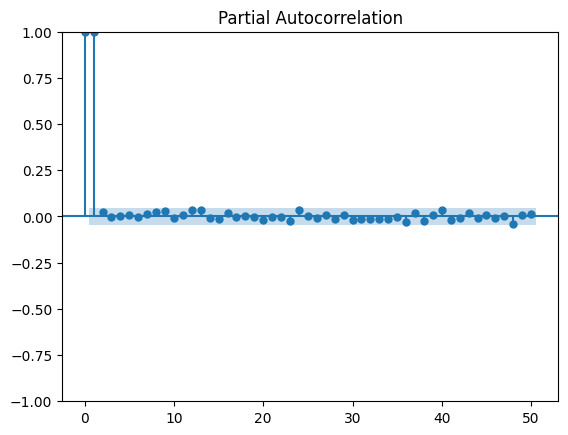

In [30]:
plot_pacf(pm.data['Spread_Close'],lags=50)
plt.show()

In [31]:
result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -43.978696
p-value: 0.000000


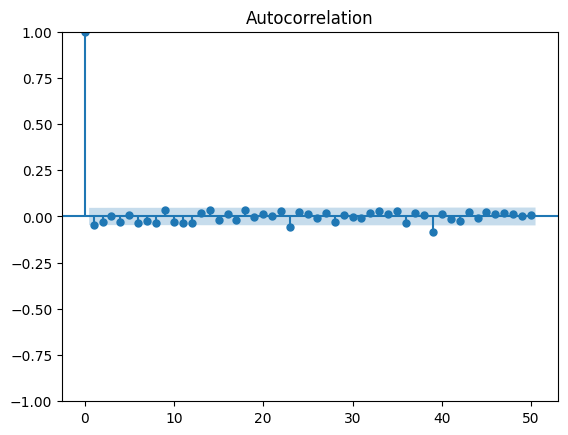

In [35]:
plot_acf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

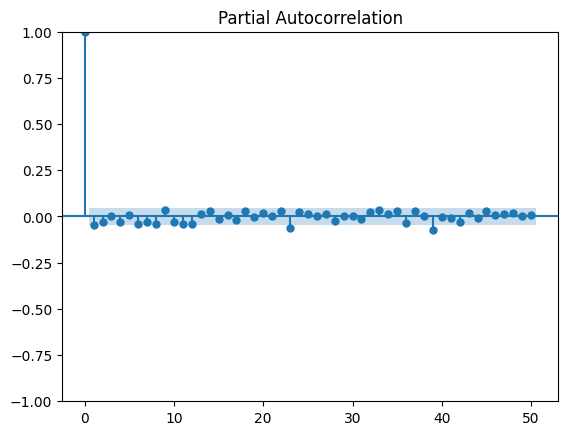

In [37]:
plot_pacf(pm.data['Spread_Close'].diff().dropna(),lags=50)
plt.show()

In [39]:

result = adfuller(pm.data['Spread_Close'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -43.978696
p-value: 0.000000
